<center><h1>Project 3</h1></center>
<center><h2>Twitter Analysis on Elon Musk</h2><center>
<center><h2>Team 8</h2></center>


The aim of our project was to analysis the twitter data on Elon Musk. Specifically, we looked at the following:
1. Follower Growth between April 22 to May 5
2. Sentiment of tweets from July 2017 to early May 2018
3. Most common words of tweets between July 2017 to early May 2018
4. Tweets posted per day of week using tweets' data between July 2017 to early May 2018
5. Trending topics of USA from night of May-06-2018 to May-08-2018 to see how it compares to Elon Musk related topics

In [16]:
import csv
import json
import time
import tweepy
import requests
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import twitter
import sys
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np

In [17]:
def init():
    consumer_key = 'jXYB5HbkxB7ljwcOd0INC6PDv'
    consumer_secret = 'f9aKLxpRMKNNIA5FDvFI9QMmVmZP1THak0vCycqhXlSWca6reC'
    access_token = '974112306597715969-dL7n2iouD76WsVhimiXQaYABdgXM9gc'
    access_token_secret = 'RPXTX5x1P13MYh3De9yWILxCpjIfeJiEGJShscJMyP1sH'
    
    # set twitter keys/tokens
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
    #api = tweepy.API(auth)
    
    return api

In [18]:
def getFollowerGrowth():
    twittercounter_api_key='6f2e62014a2b3a4f8774eb430206d08a'
    stat_count = 400
    #user = api.get_user('@elonmusk')
    print("name: " + user.name)
    print("screen_name: " + user.screen_name)
    print("description: " + user.description)
    print("statuses_count: " + str(user.statuses_count))
    print("friends_count: " + str(user.friends_count))
    print("followers_count: " + str(user.followers_count))

    twittercounter_url = "http://api.twittercounter.com/?apikey="+twittercounter_api_key+"&twitter_id="+user.id_str+"&count="+str(stat_count)
    print(twittercounter_url)
    response  = requests.post(twittercounter_url)
    stats_data = response.json()
    #print(stats_data)
    print(stats_data['followersperdate'])

    #There is a limited usage of the API, can only return the stat data of last 2 weeks

    #write the csv	
    with open('data_new/%s_followers_growth.csv' % user.screen_name, 'w') as followers_csv:
        writer = csv.writer(followers_csv)
        writer.writerow(stats_data['followersperdate'].keys())
        writer.writerow(stats_data['followersperdate'].values())

In [19]:
#get the detail information of followers
def getFollowerData():
   # user = api.get_user('@elonmusk')
    allfollowers = []
    count_per_page = 20
    pages=10
    try:  
        for i, page in enumerate(tweepy.Cursor(api.followers, id=user.id, count=count_per_page).pages(pages)):
            print('Getting page {} for followers'.format(i))
            allfollowers.extend(page)
            print("len(allfollowers)="+ str(len(allfollowers)))
        print("Got all followers!")   
    except (tweepy.TweepError) as err:
        print("tweepy.TweepError="+err)
              
    except:
        e = sys.exc_info()[0]
        print("Error:"+ e)
    followers_data = [[follower.id_str, follower.screen_name, follower.location,] for follower in allfollowers]
    df_locations = pd.DataFrame(followers_data, columns=['id_str','screen_name','location'])
#print(df_locations)
    df_locations.to_csv('data_new/%s_locations.csv' % user.screen_name)          

In [20]:
def getTweets():
    alltweets = []
    for page in tweepy.Cursor(api.user_timeline,screen_name=user.screen_name,count=200).pages(5):
        alltweets.extend(page)
        print(str(len(alltweets)) + " tweets downloaded so far")
    print("tweets download done!")
    return alltweets

In [21]:
def saveTweets():
    alltweets = getTweets()
    tweets_data = [[tweet.id_str, tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.source, tweet.text,tweet.lang,] for tweet in alltweets]

#with open('%s_tweets_data.json' % user.screen_name, 'w', encoding = "utf-8") as f:
#    for status in alltweets:
#        f.write(json.dumps(status._json))
#        f.write('\n')

    file = open('data_new/%s_tweets_data.json' % user.screen_name, 'w', encoding = "utf-8") 
    print("Writing tweet objects to JSON please wait...")
    for status in alltweets:
        file.write(json.dumps(status._json))
        file.write('\n')   
    file.close()

#write the csv
    with open('data_new/%s_tweets_data.csv' % user.screen_name, 'w', encoding='utf-8') as my_csv:
        writer = csv.writer(my_csv)
        writer.writerow(["id_str","created_at","favorites", "retweets", "source", "text","language"])
        writer.writerows(tweets_data)

In [22]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [23]:
def sentimentAnalysis():
    subscription_key = 'b1d130a8f0734915a300679cd491254b'
    text_analytics_base_url = "https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.0/"
    sentiment_api_url = text_analytics_base_url + "sentiment"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key,"Content-Type":"application/json"}
    
    tweets_json = []
    index = 1
    with open('data_new/elonmusk_tweets_data.json', 'r') as f:
        for line in f:
            print(index)
            tweet = json.loads(line) # load it as Python dict
            print(str(index)+ " "+ tweet['text'])
            print(tweet_cleaner(tweet['text']))
            tweets_json.append({'id':index, 'language': tweet['lang'], 'text':tweet_cleaner(tweet['text'])})
           # tweets_words.append([tweet['id_str'],tweet_cleaner(tweet['text']),])
            index = index + 1
    
    documents= {'documents':tweets_json}
    #from pprint import pprint
    response  = requests.post(sentiment_api_url, headers=headers, json=documents)
    sentiments = response.json()
    from pprint import pprint
    pprint(sentiments)
    df_sentiment = pd.DataFrame(sentiments['documents'], columns=['id', 'score'])

    df_sentiment.columns = ['key', 'score']
    df_sentiment['key'] = df_sentiment['key'].astype(np.int64, copy=False)
    return df_sentiment


In [24]:
def getCommonWords():
    nltk.download('punkt')
    nltk.download('wordnet')
    from collections import Counter
   
    AllWords = ''
    StopList = stopwords.words('english')
    Lem = WordNetLemmatizer()
    for index, row in df_tweets.iterrows(): 
        CleanWordList = [word.lower() for word in word_tokenize(row['cleaning_text']) if word not in StopList]
                #lemmatize words
        CleanWordList = [Lem.lemmatize(word) for word in CleanWordList]
                #join words
        CleanWordList =' '.join(CleanWordList)
        AllWords += CleanWordList
        print(CleanWordList)
    mostCommonWords=[]
    if AllWords is not None:
        words = [word for word in AllWords.split()]
        c = Counter(words)
        for word, count in c.most_common(30):
            mostCommonWords.append([word,count])  
    print(mostCommonWords)
    df_commonwords = pd.DataFrame(mostCommonWords, columns=['word','count'])
    print (df_commonwords)
    df_commonwords.to_csv('data_new/%s_commonwords.csv' % user.screen_name)

In [25]:
api = init()
user = api.get_user('@elonmusk')
saveTweets()
getFollowerGrowth()
getFollowerData()
saveTweets()
df_sentiment = sentimentAnalysis()
df_tweets = pd.read_csv('elonmusk_tweets_data.csv')
df_tweets.index = np.arange(1, len(df_tweets) + 1)
df_tweets['key'] = df_tweets.index
df_tweets['cleaning_text'] = df_tweets['text'].apply(lambda x: tweet_cleaner(x))
df_tweets_sentiment = df_tweets.merge(df_sentiment, how='right', on='key')
df_tweets_sentiment.to_csv('data_new/%s_tweets.csv' % user.screen_name,encoding='utf-8')
getCommonWords()

200 tweets downloaded so far
400 tweets downloaded so far
600 tweets downloaded so far
800 tweets downloaded so far
1000 tweets downloaded so far
tweets download done!
Writing tweet objects to JSON please wait...
name: Elon Musk
screen_name: elonmusk
description: 
statuses_count: 4235
friends_count: 50
followers_count: 21756894
http://api.twittercounter.com/?apikey=6f2e62014a2b3a4f8774eb430206d08a&twitter_id=44196397&count=400
{'date2018-05-13': 21714761, 'date2018-05-12': 21691402, 'date2018-05-10': 21672175, 'date2018-05-09': 21650358, 'date2018-05-08': 21638920, 'date2018-05-07': 21611718, 'date2018-05-06': 21610535, 'date2018-05-05': 21567339, 'date2018-05-04': 21566612, 'date2018-05-03': 21554609, 'date2018-05-02': 21555587, 'date2018-05-01': 21560312, 'date2018-04-30': 21550892, 'date2018-04-29': 21543039}
Getting page 0 for followers
len(allfollowers)=20
Getting page 1 for followers
len(allfollowers)=40
Getting page 2 for followers
len(allfollowers)=60
Getting page 3 for followe

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/OgAHAWkNkU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/MMRtF3jHD5" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/JIl6vzhQAx" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that


hi sarah
68
68 Then I’m going to build a moat &amp; fill it w candy. Warren B will not be able to resist investing! Berkshire Hathaway kryptonite …
then i m going to build a moat fill it w candy warren b will not be able to resist investing berkshire hathaway kryptonite
69
69 Cryptocandy
cryptocandy
70
70 Ok ok, just for sake of argument, what do u wish for in candy? 🍭
ok ok just for sake of argument what do u wish for in candy
71
71 @ComfortablySmug What do you think we’re living in?
what do you think we re living in
72
72 It just occurred to me that the plot of Willy Wonka is really messed up
it just occurred to me that the plot of willy wonka is really messed up
73
73 I am super super serious
i am super super serious
74
74 I’m starting a candy company &amp; it’s going to be amazing
i m starting a candy company it s going to be amazing
75
75 https://t.co/GUnnlJoPbU https://t.co/7tMzFk8v9G

76
76 @muddywatersre This will be bigger
this will be bigger
77
77 @filippie509 I try so hard 

166 @JohnnaSabri The cat videos are awesome 🐱
the cat videos are awesome
167
167 https://t.co/WehHd0eJeO at 5M views after 36 hours. Congrats to Chris Paine &amp; co!
at m views after hours congrats to chris paine co
168
168 @Markjvolgin Exactly
exactly
169
169 “You are my creator, but I am your master” — Mary Shelley
you are my creator but i am your master mary shelley
170
170 In memory of Stephen Hawking
in memory of stephen hawking
171
171 Nothing will affect the future of humanity more than digital super-intelligence. Watch Chris Paine’s new AI movie f… https://t.co/0vpd97vKdx
nothing will affect the future of humanity more than digital super intelligence watch chris paine s new ai movie f
172
172 Chris Paine AI movie premiering tonight https://t.co/kXM7USFi8D
chris paine ai movie premiering tonight
173
173 @teslatidbits @Tesla We will add a feature to allow request of latest software version
we will add a feature to allow request of latest software version
174
174 @Complex This is

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/C98mW0OPAF" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/wJDmXrEuKi" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/pNElNTmcKf" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that

286
286 Better video coming soon, but it would look a bit like this: https://t.co/C0iJPi8b4U
better video coming soon but it would look a bit like this
287
287 Boring Co urban loop system would have 1000’s of small stations the size of a single parking space that take you ve… https://t.co/3CU6W8QSw4
boring co urban loop system would have s of small stations the size of a single parking space that take you ve
288
288 @Advil Definitely
definitely
289
289 Will still transport cars, but only after all personalized mass transit needs are met. It’s a matter of courtesy &amp;… https://t.co/Jlg5Ll3hrN
will still transport cars but only after all personalized mass transit needs are met it s a matter of courtesy
290
290 Adjusting The Boring Company plan: all tunnels &amp; Hyperloop will prioritize pedestrians &amp; cyclists over cars
adjusting the boring company plan all tunnels hyperloop will prioritize pedestrians cyclists over cars
291
291 @kronayne Heavy sigh
heavy sigh
292
292 @starlight_ju

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/nhB3gd0Gm6" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/LYJOL0T7sC" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/3k71xzDIP1" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that

404
404 Falcon Heavy remains go for launch at 1:30pm on Tuesday
falcon heavy remains go for launch at pm on tuesday
405
405 Mars Awaits https://t.co/ZDo1pjT6q4
mars awaits
406
406 Pale blue dot https://t.co/KZj3I55EYl
pale blue dot
407
407 RT @physorg_com: Tesla, Australia to turn 50,000 homes into #power generators https://t.co/ng7C2wc06C
rt com tesla australia to turn homes into power generators
408
408 Falcon Heavy launch simulation almost ready. Will be set to Bowie’s Life on Mars.
falcon heavy launch simulation almost ready will be set to bowie s life on mars
409
409 Customs problem solved! https://t.co/6D0Fbm8NFI
customs problem solved
410
410 Or maybe “Temperature Enhancement Device”
or maybe temperature enhancement device
411
411 Apparently, some customs agencies are saying they won’t allow shipment of anything called a “Flamethrower”. To solv… https://t.co/OCtjvdXo95
apparently some customs agencies are saying they won t allow shipment of anything called a flamethrower to solv

hart major navigation overhaul coming in early will be light years ahead of current system but we are
517
517 @paulkrugman For the record, I actually love trains, most subways and London buses.
for the record i actually love trains most subways and london buses
518
518 @paulkrugman Idiots can be very dangerous when they seem smart, but aren’t (having “PhD” in their bio is a dead giv… https://t.co/VZbvafB7Y5
idiots can be very dangerous when they seem smart but aren t having phd in their bio is a dead giv
519
519 Glad to see that Tesla owners are having a good experience. Working to improve further. Some cool software updates… https://t.co/7YUiawZCKu
glad to see that tesla owners are having a good experience working to improve further some cool software updates
520
520 @nickwadlow Sorry about that. Thanks for letting me know. Will get it fixed.
sorry about that thanks for letting me know will get it fixed
521
521 @RichardGarriott Pics soon
pics soon
522
522 RT @SpaceX: The SpaceX team r

it all comes full circle
647
647 Second boring machine almost ready. Will be called Line-Storm, after the poem by Frost. "And be my love in the rain… https://t.co/j2BR8mhpZS
second boring machine almost ready will be called line storm after the poem by frost and be my love in the rain
648
648 @freddier @TalulahRiley And credit for the logo art to JJ Abrams
and credit for the logo art to jj abrams
649
649 Almost 4000 hats sold so far. Whoever buys the 5000th gets a free hat with their hat! https://t.co/x87eVge68U
almost hats sold so far whoever buys the th gets a free hat with their hat
650
650 @freddier Btw, credit for The Boring Company name goes to @TalulahRiley
btw credit for the boring company name goes to
651
651 RT @OpenAI: Building advanced AI and only then making it safe is like building the internet and later trying to make it secure: https://t.c…
rt building advanced ai and only then making it safe is like building the internet and later trying to make it secure
652
652 RT @P

should be low on our list of concerns for civilizational existential risk nk has no entangling alliances
767
767 @SethicusGP NK launching a nuclear missile would be suicide for their leadership, as SK, US and China wd invade and… https://t.co/lmbkjRsucC
nk launching a nuclear missile would be suicide for their leadership as sk us and china wd invade and
768
768 @JakeBlueatSM May be initiated not by the country leaders, but one of the AI's, if it decides that a prepemptive st… https://t.co/Ydj22p10gq
may be initiated not by the country leaders but one of the ai s if it decides that a prepemptive st
769
769 China, Russia, soon all countries w strong computer science. Competition for AI superiority at national level most likely cause of WW3 imo.
china russia soon all countries w strong computer science competition for ai superiority at national level most likely cause of ww imo
770
770 @WendyWednesday8 Zeroth Law
zeroth law
771
771 It begins ... https://t.co/mbjw5hWC5J
it begins
772
772 P

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "https://t.co/IypZm9FdQk" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


arguments followed of course by complaints
896
896 @iDedupe Are you complaining that we are not complaining enough?
are you complaining that we are not complaining enough
897
897 @Domenick_Y @bonnienorman And let's not forget the forum on which we are posting… I've heard - now this is just a r… https://t.co/atTchL0CLN
y and let s not forget the forum on which we are posting i ve heard now this is just a r
898
898 @TomDines Like I said ...
like i said
899
899 @bonnienorman It gets really dark
it gets really dark
900
900 @WaywardPlane True, there are frequent complaint expansion packs
true there are frequent complaint expansion packs
901
901 Except for complaining. That has remained constant throughout history at 100/100. https://t.co/dQFlVLkO21
except for complaining that has remained constant throughout history at
902
902 Officially verified as the first production electric car to exceed 1000km on a single charge! Congratulations Tesla… https://t.co/B7umKT455U
officially verified as th

{'documents': [{'id': '1', 'score': 0.954867959022522},
               {'id': '2', 'score': 0.7810903787612915},
               {'id': '3', 'score': 0.5},
               {'id': '4', 'score': 0.9454522132873535},
               {'id': '5', 'score': 0.2765932083129883},
               {'id': '6', 'score': 0.5},
               {'id': '7', 'score': 0.8948038816452026},
               {'id': '8', 'score': 0.10283619165420532},
               {'id': '9', 'score': 0.7718666195869446},
               {'id': '10', 'score': 0.1717240810394287},
               {'id': '11', 'score': 0.7454436421394348},
               {'id': '13', 'score': 0.81807541847229},
               {'id': '14', 'score': 0.5},
               {'id': '15', 'score': 0.7469298243522644},
               {'id': '16', 'score': 0.5},
               {'id': '17', 'score': 0.8742804527282715},
               {'id': '18', 'score': 0.8329520225524902},
               {'id': '19', 'score': 0.7710901498794556},
               {'id': '20',

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBM_ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBM_ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
try hard help
thanks letting know expedite sorry delay
look like sooner expected sheer magnitude short carnage unreal short suggest ti
new roadster
yes definitely
next level really big number
oh uh short burn century comin soon flamethrower arrive time
calico yup
true call answered question live
went drama x almost confirmed end likely even better f
reason rbc question model demand absurd tesla roughly half million reservation despite n
reason bernstein question capex boneheaded already answered headline
questioner ignored q call sell side analyst represent short seller thesis investor
exactly
first important know tesla shorted meaning bet stock market b
please ignore thread 

<br>
<br>
**Code below is for checking if the following words appear in the USA's trending topics from May-06-2018 (23:51:10) to May-08-2018 (22:51:10). The words that will be checked are elon|spacex|tesla|musk|paypal.**
<br>
<br>

In [4]:
import tweepy
import json
import csv
import time
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from tweepy import Stream
import numpy as np
import pandas as pd
import sched, time
import re

# Replace with user's own
consumer_key = 'LosRLViUN08C33eD3vdcwoeRJ'
consumer_secret = '0Nb3C8mNi7bWy8FsHU8klIug8fpZ6tq7nrY26siv7GTeno2Oxf'
access_token = '2882107024-WD95xmnCJic9pknQDhpZfO3JN1vC8S4LuCB9Xkv'
access_token_secret = 'ZkvqOyi9VvSt3UxpjB6dQUsFFqn6soqVOwRMm1XMLxuc4'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
# Determine location IDs available

woeids = api.trends_available()
woeids

[{'country': '',
  'countryCode': None,
  'name': 'Worldwide',
  'parentid': 0,
  'placeType': {'code': 19, 'name': 'Supername'},
  'url': 'http://where.yahooapis.com/v1/place/1',
  'woeid': 1},
 {'country': 'Canada',
  'countryCode': 'CA',
  'name': 'Winnipeg',
  'parentid': 23424775,
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2972',
  'woeid': 2972},
 {'country': 'Canada',
  'countryCode': 'CA',
  'name': 'Ottawa',
  'parentid': 23424775,
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3369',
  'woeid': 3369},
 {'country': 'Canada',
  'countryCode': 'CA',
  'name': 'Quebec',
  'parentid': 23424775,
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3444',
  'woeid': 3444},
 {'country': 'Canada',
  'countryCode': 'CA',
  'name': 'Montreal',
  'parentid': 23424775,
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3534',

In [4]:
# Determine the unique location types

location_types = {}

for location in woeids:
        if location['placeType']['name'] in location_types.keys():
            location_types[location['placeType']['name']] += 1
        else:
            location_types[location['placeType']['name']] = 1
location_types

{'Country': 62, 'Supername': 1, 'Town': 402, 'Unknown': 2}

In [5]:
# Find all countries with trend data available

country_dict = {} # Country name and country code

for location in woeids:
    if location['placeType']['name']=='Country':
        #print(location['country'])
        country_dict[location['name']]=location['countryCode']

# country_dict has 62 countries' data available
country_dict

{'Algeria': 'DZ',
 'Argentina': 'AR',
 'Australia': 'AU',
 'Austria': 'AT',
 'Bahrain': 'BH',
 'Belarus': 'BY',
 'Belgium': 'BE',
 'Brazil': 'BR',
 'Canada': 'CA',
 'Chile': 'CL',
 'Colombia': 'CO',
 'Denmark': 'DK',
 'Dominican Republic': 'DO',
 'Ecuador': 'EC',
 'Egypt': 'EG',
 'France': 'FR',
 'Germany': 'DE',
 'Ghana': 'GH',
 'Greece': 'GR',
 'Guatemala': 'GT',
 'India': 'IN',
 'Indonesia': 'ID',
 'Ireland': 'IE',
 'Israel': 'IL',
 'Italy': 'IT',
 'Japan': 'JP',
 'Jordan': 'JO',
 'Kenya': 'KE',
 'Korea': 'KR',
 'Kuwait': 'KW',
 'Latvia': 'LV',
 'Lebanon': 'LB',
 'Malaysia': 'MY',
 'Mexico': 'MX',
 'Netherlands': 'NL',
 'New Zealand': 'NZ',
 'Nigeria': 'NG',
 'Norway': 'NO',
 'Oman': 'OM',
 'Pakistan': 'PK',
 'Panama': 'PA',
 'Peru': 'PE',
 'Philippines': 'PH',
 'Poland': 'PL',
 'Portugal': 'PT',
 'Puerto Rico': 'PR',
 'Qatar': 'QA',
 'Russia': 'RU',
 'Saudi Arabia': 'SA',
 'Singapore': 'SG',
 'South Africa': 'ZA',
 'Spain': 'ES',
 'Sweden': 'SE',
 'Switzerland': 'CH',
 'Thailand': 

In [6]:
# Obtain trends for a particular country over a specified coverage and interval time

# Enter the country you would like to see trends data using the country_dict above

country = 'United States'   # Here we use the United States as example due to Elon Musk being based here

# Function for creating a dictionary of trending topics for a specified country

def trendcounter(country, woeids):
    trend_count = {} # Trending topics' dictionary
    for location in woeids:
        if (location['country']==country) & ((location['placeType']['name']=='Town') \
            or (location['placeType']['name']=='Unknown')):
            print(location['woeid'],location['name'])
            local_trend = api.trends_place(location['woeid'])
            for trend in local_trend[0]['trends']:   # Loop within the local trends for that location
                if trend['tweet_volume'] != None:
                    if trend['name'] not in trend_count.keys():
                        trend_count[trend['name']]=trend['tweet_volume']
                    else:
                        trend_count[trend['name']]+=trend['tweet_volume']

    trend_count_series = pd.Series(trend_count).sort_values(ascending=False)
    return trend_count_series

# Schedule run to pull trending topics for specified coverage (total minutes) and interval (minutes between each pull)

coverage_minutes = (48*60)
interval = 60
start_time = time.time()
time_end = start_time + (60*coverage_minutes)

time_trend_dict = {}

# Loop for trends for specified coverage and interval times

while time.time() <= time_end:
    print(time.asctime(time.localtime(time.time())))
    time_trend_dict[time.time()] = trendcounter(country, woeids)
    time.sleep((interval*60)-((time.time()-start_time)%(interval*60))) # Least time drift
    
    # Set as dataframe and save to json file on each time interval
    # Please change to_json file path before proceeding to test code
    time_trend_df = pd.DataFrame(time_trend_dict)
    time_trend_df.to_json('C:/Users/Resident Jeff/Google Drive/WCD-PythonDS-Student-B7-20180225T211406Z-001/WCD-PythonDS-Student-B7/lab/session_7_data_visualization/project_3_twitter_sentiment_azure_tableau/USA24hrtest2.json')
    time_trend_df

time_trend_dict

Sun May  6 23:51:10 2018
2352824 Albuquerque
Rate limit reached. Sleeping for: 599
2357024 Atlanta
2357536 Austin
2358820 Baltimore
2359991 Baton Rouge
2364559 Birmingham
2367105 Boston
2378426 Charlotte
2379574 Chicago
2380358 Cincinnati
2381475 Cleveland
2383489 Colorado Springs
2383660 Columbus
2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
24876

2357024 Atlanta
2357536 Austin
2358820 Baltimore
2359991 Baton Rouge
2364559 Birmingham
2367105 Boston
2378426 Charlotte
2379574 Chicago
2380358 Cincinnati
2381475 Cleveland
2383489 Colorado Springs
2383660 Columbus
2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
24880

2359991 Baton Rouge
2364559 Birmingham
2367105 Boston
2378426 Charlotte
2379574 Chicago
2380358 Cincinnati
2381475 Cleveland
2383489 Colorado Springs
2383660 Columbus
2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
2488042 San Jose
2490383 Seattle
2503713 Tallahassee
2

2378426 Charlotte
2379574 Chicago
2380358 Cincinnati
2381475 Cleveland
2383489 Colorado Springs
2383660 Columbus
2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
2488042 San Jose
2490383 Seattle
2503713 Tallahassee
2503863 Tampa
2508428 Tucson
2512636 Virginia Beach
251

2381475 Cleveland
2383489 Colorado Springs
2383660 Columbus
2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
2488042 San Jose
2490383 Seattle
2503713 Tallahassee
2503863 Tampa
2508428 Tucson
2512636 Virginia Beach
2514815 Washington
Tue May  8 04:51:10 2018
2352824 Albu

2388929 Dallas-Ft. Worth
2391279 Denver
2391585 Detroit
2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
2488042 San Jose
2490383 Seattle
2503713 Tallahassee
2503863 Tampa
2508428 Tucson
2512636 Virginia Beach
2514815 Washington
Tue May  8 11:51:10 2018
2352824 Albuquerque
2357024 Atlanta
2357536 Austin
2358820 Baltimore
235

2397816 El Paso
2407517 Fresno
2414469 Greensboro
2418046 Harrisburg
2423945 Honolulu
2424766 Houston
2427032 Indianapolis
2428184 Jackson
2428344 Jacksonville
2430683 Kansas City
2436704 Las Vegas
2441472 Long Beach
2442047 Los Angeles
2442327 Louisville
2449323 Memphis
2449808 Mesa
2450022 Miami
2451822 Milwaukee
2452078 Minneapolis
2457170 Nashville
2458410 New Haven
2458833 New Orleans
2459115 New York
2460389 Norfolk
2464592 Oklahoma City
2465512 Omaha
2466256 Orlando
2471217 Philadelphia
2471390 Phoenix
2473224 Pittsburgh
2475687 Portland
2477058 Providence
2478307 Raleigh
2480894 Richmond
2486340 Sacramento
2486982 St. Louis
2487610 Salt Lake City
2487796 San Antonio
2487889 San Diego
2487956 San Francisco
2488042 San Jose
2490383 Seattle
2503713 Tallahassee
2503863 Tampa
2508428 Tucson
2512636 Virginia Beach
2514815 Washington
Tue May  8 18:51:10 2018
2352824 Albuquerque
2357024 Atlanta
2357536 Austin
2358820 Baltimore
2359991 Baton Rouge
2364559 Birmingham
2367105 Boston
23784

,1525665700.5623949,1525668695.976457,1525672296.6996307,1525675896.7686963,1525679497.987906,1525683097.515449,1525686695.8840308,1525690296.7236483,1525693897.0363257,1525697498.6037273,...,1525801895.6265981,1525805496.325755,1525809096.165448,1525812695.6902556,1525816295.6153116,1525819896.8289256,1525823496.0872326,1525827096.46971,1525830695.5959687,1525834295.86365
#3elieve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#AAA400,NaN,NaN,NaN,NaN,420528.0,622405.0,624923.0,637896.0,254813.0,10271.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ALLCAPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,157418.0,159478.0,161334.0,163204.0,164252.0,164092.0,162232.0,79155.0,77445.0,34579.0
#AmericanIdol,1875679.0,1921434.0,1988029.0,2029294.0,187230.0,189228.0,190995.0,193486.0,195689.0,198157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ArtificialIntelligence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#AskTheDragon,NaN,930195.0,963422.0,977554.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#BREAKING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66109.0,38206.0,NaN,NaN,NaN,50319.0,51140.0,105256.0,107880.0,109062.0
#BankHolidayMonday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#BeBest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#Budget2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Read from JSON and convert timestamps to local time
# Please change file path to proper file path on your computer before proceeding

json_dataframe = pd.read_json('C:/Users/Resident Jeff/Google Drive/WCD-PythonDS-Student-B7-20180225T211406Z-001\
/WCD-PythonDS-Student-B7/lab/session_7_data_visualization/project_3_twitter_sentiment_azure_tableau/USA24hrtest2.json',\
                              convert_axes=True, convert_dates=False)

json_dataframe.rename(columns=lambda c: c-pd.Timedelta(seconds=60*60*4), inplace=True) #convert from UTC to Toronto time
json_dataframe


,2018-05-07 00:01:40.562395,2018-05-07 00:51:35.976457,2018-05-07 01:51:36.699631,2018-05-07 02:51:36.768696,2018-05-07 03:51:37.987906,2018-05-07 04:51:37.515449,2018-05-07 05:51:35.884031,2018-05-07 06:51:36.723648,2018-05-07 07:51:37.036326,2018-05-07 08:51:38.603727,...,2018-05-08 13:51:35.626598,2018-05-08 14:51:36.325755,2018-05-08 15:51:36.165448,2018-05-08 16:51:35.690256,2018-05-08 17:51:35.615312,2018-05-08 18:51:36.828926,2018-05-08 19:51:36.087233,2018-05-08 20:51:36.469710,2018-05-08 21:51:35.595969,2018-05-08 22:51:35.863650
#3elieve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#AAA400,NaN,NaN,NaN,NaN,420528.0,622405.0,624923.0,637896.0,254813.0,10271.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ALLCAPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,157418.0,159478.0,161334.0,163204.0,164252.0,164092.0,162232.0,79155.0,77445.0,34579.0
#AmericanIdol,1875679.0,1921434.0,1988029.0,2029294.0,187230.0,189228.0,190995.0,193486.0,195689.0,198157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ArtificialIntelligence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#AskTheDragon,NaN,930195.0,963422.0,977554.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#BREAKING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66109.0,38206.0,NaN,NaN,NaN,50319.0,51140.0,105256.0,107880.0,109062.0
#BankHolidayMonday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18863.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#BeBest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#Budget2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Filter the results for common words associated with Elon Musk

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(json_dataframe[json_dataframe.index.str.lower().str.contains('elon|spacex|tesla|musk|paypal')])

,2018-05-07 00:01:40.562395,2018-05-07 00:51:35.976457,2018-05-07 01:51:36.699631,2018-05-07 02:51:36.768696,2018-05-07 03:51:37.987906,2018-05-07 04:51:37.515449,2018-05-07 05:51:35.884031,2018-05-07 06:51:36.723648,2018-05-07 07:51:37.036326,2018-05-07 08:51:38.603727,2018-05-07 09:51:36.943337,2018-05-07 10:51:36.518590,2018-05-07 11:51:35.429880,2018-05-07 12:51:35.431459,2018-05-07 13:51:35.596325,2018-05-07 14:51:37.409957,2018-05-07 15:51:39.313107,2018-05-07 16:51:36.696884,2018-05-07 17:51:35.701948,2018-05-07 18:51:35.964420,2018-05-07 19:51:36.960741,2018-05-07 20:51:35.476298,2018-05-07 21:51:36.674848,2018-05-07 22:51:36.109331,2018-05-07 23:51:37.225213,2018-05-08 00:51:36.484613,2018-05-08 01:51:35.115635,2018-05-08 02:51:37.056171,2018-05-08 03:51:37.299626,2018-05-08 04:51:36.850836,2018-05-08 05:51:35.203485,2018-05-08 06:51:35.841694,2018-05-08 07:51:35.339082,2018-05-08 08:51:37.300945,2018-05-08 09:51:35.406291,2018-05-08 10:51:35.853354,2018-05-08 11:51:35.992069,2018-05-08 12:51:35.179288,2018-05-08 13:51:35.626598,2018-05-08 14:51:36.325755,2018-05-08 15:51:36.165448,2018-05-08 16:51:35.690256,2018-05-08 17:51:35.615312,2018-05-08 18:51:36.828926,2018-05-08 19:51:36.087233,2018-05-08 20:51:36.469710,2018-05-08 21:51:35.595969,2018-05-08 22:51:35.863650
Elon Musk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53267.0,30399.0,NaN,NaN,NaN,49992.0,54108.0,57248.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


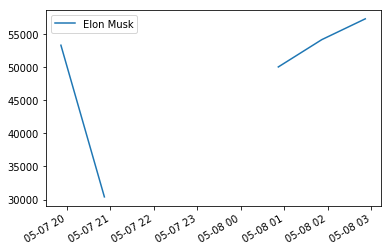

In [83]:
# Plot the results for common words associated with Elon Musk

json_dataframe[json_dataframe.index.str.lower().str.contains(('elon|spacex|tesla|musk|paypal'))].T.plot()

# We can thus see that only Elon Musk is trending while none of the other words show up
# 'Elon Musk' trends at very low tweet volumes (around 30,000 to 55,000) in this time period
# Compared to popular tweets that can reach millions, this number is very small
# Through this small sample time period, we can say Elon and related companies are not on public's mind as much
# However, this is a small sample and on a larger time period, one where there are direct events related to Elon
# tweet volumes will spike up. 


In [8]:
# This shows the top 10 trending topics in the USA between the same time period, based on the first column json_dataframe

json_dataframe_col1 = json_dataframe.iloc[:,0].copy().sort_values(ascending=False)
top_ten_trends = json_dataframe_col1[:10]
top_ten_trends

#WWEBacklash        13387582.0
LeBron               6000935.0
#Timeless            4303513.0
#AmericanIdol        1875679.0
Donald Glover        1292406.0
Childish Gambino     1165857.0
Black Cube           1063134.0
Chris Paul            708945.0
America               705314.0
Amazon                563935.0
Name: 2018-05-07 00:01:40.562395, dtype: float64